### Imports y carga de datos

In [78]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

RUTA_DATASET = Path("/content/drive/MyDrive/Alan/dataset/data/dataset.csv")

dataset = pd.read_csv(RUTA_DATASET)

if dataset["price_range"].dtype != "int64":
    dataset["price_range"] = dataset["price_range"].astype(int)

dataset["price_range"] = dataset["price_range"].replace({2:1})

print(dataset.shape)
dataset.head()

(2000, 21)


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842.0,0,2.2,0,1.0,0,7.0,0.6,188.0,2.0,...,20.0,756.0,2.0,9.0,7.0,19.0,0,0,1,1
1,1021.0,1,0.5,1,5.6,1,53.0,0.7,136.0,3.0,...,905.0,1988.0,2.0,17.0,3.0,7.0,1,1,0,1
2,563.0,1,0.5,1,2.0,1,41.0,0.9,145.0,5.0,...,1263.0,1716.0,2.0,11.0,2.0,9.0,1,1,0,3
3,615.0,1,2.5,0,5.6,0,10.0,0.8,131.0,6.0,...,1216.0,1786.0,2.0,16.0,8.0,11.0,1,0,0,1
4,1821.0,1,1.2,0,13.0,1,44.0,0.6,141.0,2.0,...,1208.0,1212.0,1.0,8.0,2.0,15.0,1,1,0,0


###Identificar variable objetivo y variables de entrada.

In [79]:
target = "price_range"
X = dataset.drop(columns=[target])
y = dataset[target]

print(f"Variables de entrada (X): {list(X.columns)}")
print(f"Variable objetivo (y): {target}")

RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

X_train.shape, X_test.shape

Variables de entrada (X): ['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g', 'touch_screen', 'wifi']
Variable objetivo (y): price_range


((1400, 20), (600, 20))

###Diseño y entrenamiento del modelo.

In [80]:
modelos = {
    "LogisticRegression": LogisticRegression(max_iter=2000, class_weight="balanced"),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM_rbf": SVC(kernel="rbf", C=1.0, gamma="scale", probability=True,
                   random_state=RANDOM_STATE, class_weight="balanced"),
    "RandomForest": RandomForestClassifier(
        n_estimators=200, max_depth=None,
        random_state=RANDOM_STATE, n_jobs=-1,
        class_weight="balanced"
    ),
}

to_scale = {"LogisticRegression", "KNN", "SVM_rbf"}

fitted = {}
for nombre, modelo in modelos.items():
  print(f"Entrenando modelo: {nombre}...")
  if nombre in to_scale:
    modelo.fit(X_train_s, y_train)
  else:
    modelo.fit(X_train, y_train)
  fitted[nombre] = modelo

list(fitted.keys())

Entrenando modelo: LogisticRegression...
Entrenando modelo: KNN...
Entrenando modelo: SVM_rbf...
Entrenando modelo: RandomForest...


['LogisticRegression', 'KNN', 'SVM_rbf', 'RandomForest']

###Métricas utilizadas

In [81]:
from sklearn.metrics import confusion_matrix

resultados = []

def evaluacion(nombre, modelo):
    X_eval = X_test_s if nombre in to_scale else X_test
    y_pred = modelo.predict(X_eval)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="weighted", zero_division=0)
    rec = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")
    resultados.append([nombre, acc, prec, rec, f1])

for nombre, modelo in fitted.items():
    evaluacion(nombre, modelo)

resultados_dataset = pd.DataFrame(resultados, columns=["Modelo", "Accuracy", "Precision", "Recall", "F1"])
resultados_dataset = resultados_dataset.sort_values("F1", ascending=False).reset_index(drop=True)
resultados_dataset

,Modelo,Accuracy,Precision,Recall,F1
0,KNN,0.388333,0.388138,0.388333,0.386988
1,RandomForest,0.518333,0.275746,0.518333,0.359985
2,SVM_rbf,0.331667,0.388995,0.331667,0.346295
3,LogisticRegression,0.331667,0.411591,0.331667,0.342559


###Optimizar el modelo

In [82]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

rf_pipe = Pipeline([
    ("rf", RandomForestClassifier(random_state=RANDOM_STATE))
])

rf_params = {
    "rf__n_estimators": [200, 400, 600],
    "rf__max_depth": [None, 10, 20],
    "rf__min_samples_split": [2, 5, 10],
    "rf__max_features": ["sqrt", "log2", None],
}

rf_grid = GridSearchCV(
    rf_pipe, rf_params, cv=5, scoring="f1_weighted",
    n_jobs=-1, refit=True, return_train_score=True
)
rf_grid.fit(X_train, y_train)
print("RF mejores params:", rf_grid.best_params_)
print("RF F1 (cv):", round(rf_grid.best_score_, 4))

svm_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(probability=True, random_state=RANDOM_STATE))
])

svm_params = {
    "svm__kernel": ["rbf"],
    "svm__C": [0.5, 1, 2, 4],
    "svm__gamma": ["scale", 0.1, 0.01, 0.001],
}

svm_grid = GridSearchCV(
    svm_pipe, svm_params, cv=5, scoring="f1_weighted",
    n_jobs=-1, refit=True, return_train_score=True
)
svm_grid.fit(X_train, y_train)
print("SVM mejores params:", svm_grid.best_params_)
print("SVM F1 (cv):", round(svm_grid.best_score_, 4))

RF mejores params: {'rf__max_depth': 20, 'rf__max_features': None, 'rf__min_samples_split': 2, 'rf__n_estimators': 400}
RF F1 (cv): 0.376
SVM mejores params: {'svm__C': 4, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}
SVM F1 (cv): 0.4305


###Comparar resultados.

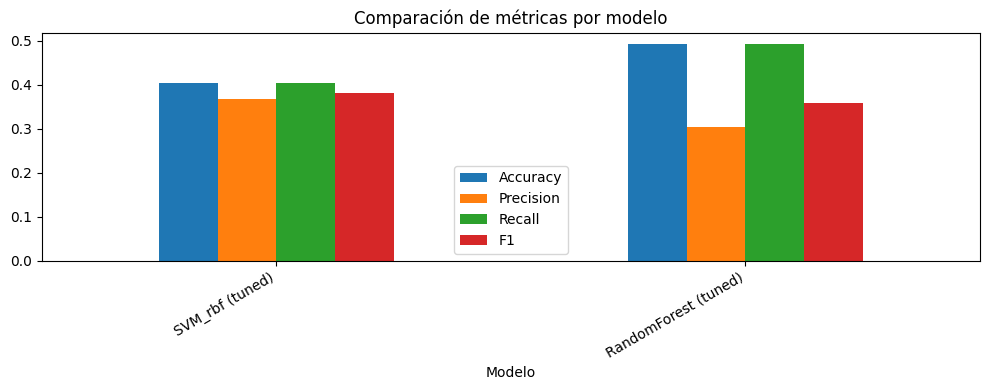

Mejor modelo final: SVM_rbf (tuned)


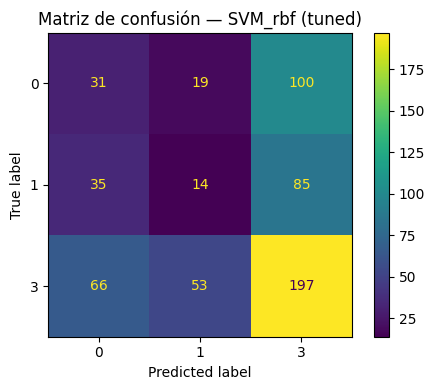

Classification report:
              precision    recall  f1-score   support

           0       0.23      0.21      0.22       150
           1       0.16      0.10      0.13       134
           3       0.52      0.62      0.56       316

    accuracy                           0.40       600
   macro avg       0.30      0.31      0.30       600
weighted avg       0.37      0.40      0.38       600



In [83]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

# Barras comparativas
ax = comparacion_df.plot(x="Modelo", y=["Accuracy","Precision","Recall","F1"],
                         kind="bar", figsize=(10,4))
plt.title("Comparación de métricas por modelo")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

# Selección del mejor
best_name = comparacion_df.iloc[0]["Modelo"]
if "RandomForest (tuned)" in best_name:
    best_clf = rf_grid.best_estimator_
    X_eval = X_test
elif "SVM_rbf (tuned)" in best_name:
    best_clf = svm_grid.best_estimator_
    X_eval = X_test
else:
    name_to_clf = {
        "LogisticRegression (base)": fitted["LogisticRegression"],
        "KNN (base)": fitted["KNN"],
        "SVM_rbf (base)": fitted["SVM_rbf"],
        "RandomForest (base)": fitted["RandomForest"],
    }
    best_clf = name_to_clf[best_name]
    X_eval = X_test_s if best_name in ["LogisticRegression (base)", "KNN (base)", "SVM_rbf (base)"] else X_test

print("Mejor modelo final:", best_name)
y_pred_best = best_clf.predict(X_eval)

# Matriz de confusión
fig, ax = plt.subplots(figsize=(5,4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_best, ax=ax)
ax.set_title(f"Matriz de confusión — {best_name}")
plt.tight_layout(); plt.show()

# Classification report
print("Classification report:")
print(classification_report(y_test, y_pred_best, zero_division=0))

In [84]:
from joblib import dump

comparacion_df.to_csv("resultados_clasificacion.csv", index=False)
print("Guardado: resultados_clasificacion.csv")

dump(best_clf, "mejor_modelo_clasificacion.joblib")
print("Guardado: mejor_modelo_clasificacion.joblib")

Guardado: resultados_clasificacion.csv
Guardado: mejor_modelo_clasificacion.joblib
